In [2]:
import numpy as np
from numpy.random import rand
import random
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from joblib import Parallel, delayed


In [15]:
class info():
    def __init__(self):
        self.lattice_const = 3.29
        self.E0 = 0
        self.kb = 8.6173303e-5 #boltzmann constant
        self.ncols = 50 #number of atoms per supercell in y
        self.nrows = 50 #number of atoms per supercell in x
        self.d1, self.d2, self.d3 = 5, 10, 15 #distance thresholds for J1,J2, and J3
        self.J1, self.J2, self.J3 = 0.049281301, 0.015225899, -0.011650972  #interaction energies (eV)
        #self.J1, self.J2, self.J3 = 0.022532397, -0.001297916, -0.020105041  #interaction energies (eV)
        self.concentration = 1 #percent concentration of dopant
        self.N_mc = 5000 #number of monte carlo iterations for equilibration
        self.N_per_T = 10 # number of atomic configurations per temperature
        self.N_t = 20 #number of temperatures to sample
        self.Tmin = .001
        self.Tmax = 700
        
    def generate_lattice(self, hexagonal = False):
        if hexagonal:
            row = []
            for i in range(self.ncols):
                row.append((0,self.lattice_const*i))
            row2 = []
            lat_mat = []
            for n in range(self.nrows):
                lat_mat.append(row)
                for i in row:
                    row2.append((i[0]+self.lattice_const*np.sqrt(3)/2, i[1]+self.lattice_const/2))
                row = row2
                row2 = []                   
            latlist = [item for sublist in lat_mat for item in sublist]
            self.latlist = latlist
        
        else:
            x1 = 0
            x2 = -self.lattice_const/2
            x2fac = -1
            x1list = []
            x2list = []
            iseven = 0
            for i in range(self.ncols):
                x1list.append(x1)
                x2list.append(x2)
                if iseven%2 ==0:
                    x1 += self.lattice_const
                else:
                    x1 += 2*self.lattice_const
                x2fac *= -1
                x2 = x1 + x2fac*self.lattice_const/2
                iseven +=1
            latlist = []
            
            for i in range(self.nrows):
                for x, val in enumerate(x1list):
#                     x1list[x] += 1.645
                    latlist.append([x1list[x],(i)*np.sqrt(3)*self.lattice_const])
                for x, val in enumerate(x2list[:-1]):
#                     x2list[x] += 1.645
                    latlist.append([x2list[x],(i)*np.sqrt(3)*self.lattice_const+np.sqrt(3)*self.lattice_const/2])
            for i, val in enumerate(latlist):
                latlist[i][0] += 1.645
            self.latlist = latlist
 

    def check_for_neigbors(self, position):
        neighbors =[]
        d1, d2, d3 = self.d1, self.d2, self.d3
        Lx = self.ncols*self.lattice_const
        Ly = self.nrows*self.lattice_const*np.sqrt(3)
        for i, atom in enumerate(self.latlist):
            if atom != position:
                xdiff = np.abs(position[0] - atom[0])
                ydiff = np.abs(position[1] - atom[1])
                
                #xdiff=xdiff-np.rint(xdiff/Lx)*Lx
                #ydiff=ydiff-np.rint(ydiff/Ly)*Ly
                
                dist = np.sqrt(xdiff**2 + ydiff**2)
                
                if dist <= d1:
                    neighbors.append((i,1,dist))
                elif dist <= d2 and dist > d1:
                    neighbors.append((i,2,dist))
                elif dist <= d3 and dist > d2:
                    neighbors.append((i,3,dist))
                else:
                    pass
        return neighbors

    def plot_lattice(self):
        x_val = [x[0] for x in self.latlist]
        y_val = [x[1] for x in self.latlist] 
        plt.scatter(x_val,y_val)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.show()

def get_total_energy(spin_dict, dopant_neighbors, info):
    H1, H2, H3 =0,0,0
    for dopant in dopant_neighbors:
        for neighbor in dopant_neighbors[dopant]:
            if neighbor[1] == 1:
                H1 += spin_dict[dopant]*spin_dict[neighbor[0]]*info.J1
            elif neighbor[1] == 2:
                H2 += spin_dict[dopant]*spin_dict[neighbor[0]]*info.J2
            elif neighbor[1] == 3:
                H3 += spin_dict[dopant]*spin_dict[neighbor[0]]*info.J3
    return info.E0 -(H1 + H2 + H3)/2


def monte_carlo(spin_dict, T, dopant_neighbors, info):
    '''Monte Carlo move using Metropolis algorithm '''
    beta = 1/(info.kb*T)
    init_E = get_total_energy(spin_dict, dopant_neighbors, info)
    
    ind = random.choice(list(spin_dict))
    spin_dict[ind]*=-1    
    
    fin_E = get_total_energy(spin_dict, dopant_neighbors, info)
    
    delta_E = fin_E - init_E
    if delta_E < 0:
        return spin_dict, fin_E
    elif rand() < np.exp(-delta_E*beta):
        return spin_dict, fin_E
    else:
        spin_dict[ind]*=-1
        return spin_dict, fin_E

def calc_mag(spin_dict):
    return np.sum(list(spin_dict.values()))    

def run_mc_loop(T, info):
    latlist = info.latlist
    dopants = random.sample(range(1, len(latlist)), int(len(latlist)*info.concentration/100))
    spin_dict = {}
    neighbor_dict = {}
    dopant_neighbors = {}
    spins = [-1, 1]
    for dopant in dopants:
        spin_dict[dopant] = 1
        #spin_dict[dopant] = np.random.choice(spins)
        neighbor_dict[dopant] = info.check_for_neigbors(latlist[dopant])
        dopant_neighbors[dopant] = []
        for i in neighbor_dict[dopant]:
            if i[0] in dopants:
                dopant_neighbors[dopant].append(i)
    info.dopant_neighbors = dopant_neighbors
    
    spins=[]
    energies=[]
    for i in range(info.N_mc):
        spin_dict, energy = monte_carlo(spin_dict, T, dopant_neighbors, info)
        spins.append(np.abs(calc_mag(spin_dict)))
        energies.append(energy)
    return energies, spins


def run_simulation(info):
    Tlist = np.linspace(info.Tmin,info.Tmax, info.N_t)
    paramfile = "{}x{}_{}pct.csv".format(info.ncols, info.nrows,info.concentration)
    print(paramfile)
    with open(paramfile, 'w') as f:
        f.write('Temperature,Energy,Magnetization,std(E),std(M)\n')

    Elist = {}
    Mlist = {}

    for t in Tlist:
        Elist[t] = []
        Mlist[t] = []
        for i in range(info.N_per_T):
            energies, spins = run_mc_loop(t, info)
            #print("Number of dopants = {}, Average number of neighbors = {}".format(
                    #len(info.dopant_neighbors),np.mean([len(info.dopant_neighbors[x]) for x in info.dopant_neighbors])))
            #print(info.dopant_neighbors)
            Elist[t].append(np.mean(energies[-100:]))
            Mlist[t].append(np.mean(spins[-100:]))
        print("T={}, Avg E={}, std(E)={}, Avg M={}, std(M)={}".format(
            t, np.mean(Elist[t]), np.std(Elist[t]), np.mean(Mlist[t]),np.std(Mlist[t])))

        logfile = open(paramfile,"a")
        logfile.write("{},{},{},{},{}\n".format(t,np.mean(Elist[t]),np.mean(Mlist[t]),np.std(Elist[t]),np.std(Mlist[t])))
        logfile.close()

    E = []
    M = []
    for key in Elist:
        E.append(np.mean(Elist[key])/len(info.dopant_neighbors))
        M.append(np.mean(Mlist[key])/len(info.dopant_neighbors))
    plt.plot(Tlist,E)
    plt.title("Energy")
    plt.show()
    plt.plot(Tlist,M)
    plt.title("Absolute Magnetization")
    plt.show()

In [47]:
info = info()

dims = [20,30,50,70,90]
cons = [0.5,1,2,3,10]

def mc(dim,con,info):
    info.ncols, info.nrows, info.concentration = dim, dim, con
    info.generate_lattice()
    run_simulation(info)

Parallel(n_jobs=4)(mc(dim,con,info)
                    for dim in dims
                    for con in cons)


TypeError: 'info' object is not callable

In [97]:

# df = pd.DataFrame()
# df["Temperature"] = Tlist
# df["Energy"] = E
# df["Magnetization"] = M
# df.to_csv("{}x{}.csv".format(info.ncols, info.nrows))



array([ 0.25975623,  0.64348867,  0.08973515,  0.61680132,  0.88361953])

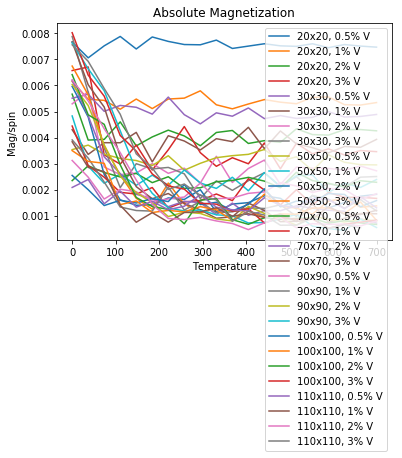

In [151]:
dims = [20,30,50,70,90,100,110]
cons = [0.5,1,2,3]

#plt.subplot()
Mlist = []
paramlist = []

for dim in dims:
    for con in cons:
        path = "{}x{}_{}pct.csv".format(dim,dim,con)
        nat = dim**2
        df1 = pd.read_csv(path)
        M1 = pd.DataFrame(df1.groupby('Temperature')['Magnetization'].mean()/(nat*con))
        E1 = pd.DataFrame(df1.groupby('Temperature')['Energy'].mean()/(nat*con))
        
        Mlist.append(M1)
        paramlist.append((dim,con))
        plt.plot(M1, label = "{}x{}, {}% V".format(dim,dim,con))
           
        plt.legend()
        plt.title("Absolute Magnetization")
        plt.xlabel("Temperature")
        plt.ylabel("Mag/spin")
        #plt.show()
plt.show()


# plt.plot(E1, label = "20")
# plt.plot(E2, label = "10")
# # plt.plot(E3, label = "40")
# # plt.plot(E4, label = "50")
# plt.legend()
# plt.title("Energy")
# plt.xlabel("Temperature")
# plt.ylabel("Energy/spin")
# plt.show()

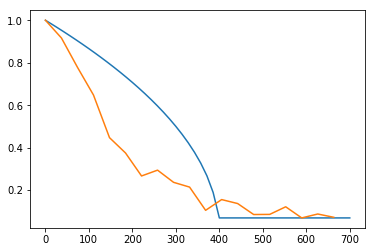

In [138]:
Tc = 400
M1 = Mlist[-1]

base = np.min(M1)[0]/np.max(M1)[0]
x = np.linspace(0.001,700)

def get_y(x,tc,beta,base=0):
    y = np.zeros(np.shape(x))
    for i, val in enumerate(x):
        if 1 - val/tc >0:
            y[i] = (1 - val/tc)**beta
        else:
            y[i] = base
    return y

y = get_y(x,Tc,base)

plt.plot(x,y)
plt.plot(M1/np.max(M1)[0], label = "{}x{}, {}% V".format(dim,dim,con))
plt.show()

(20, 0.5)


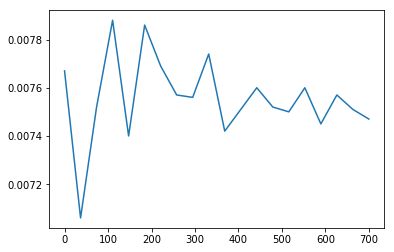

(20, 1)


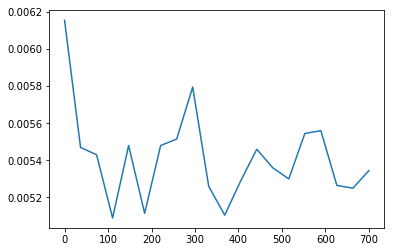

(20, 2)


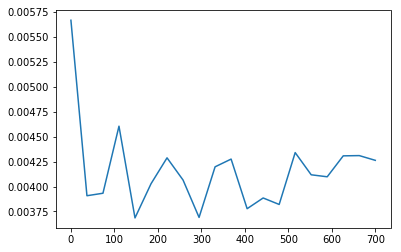

(20, 3)


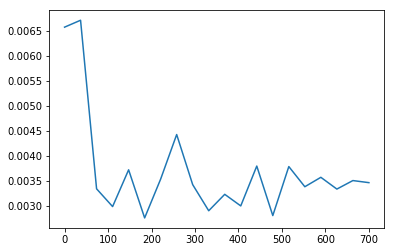

(30, 0.5)


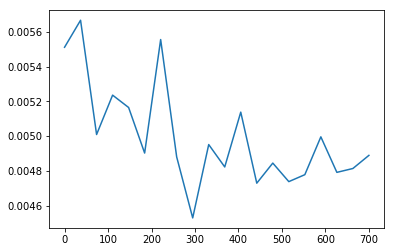

(30, 1)


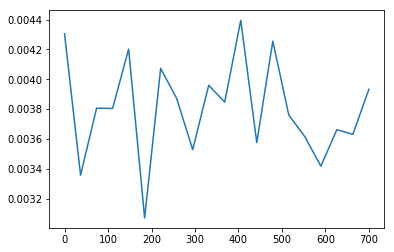

(30, 2)


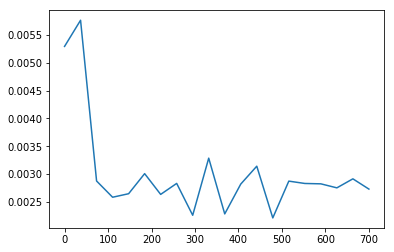

(30, 3)


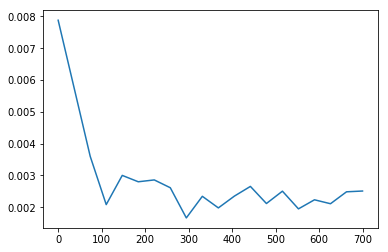

(50, 0.5)


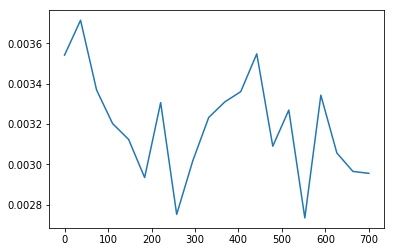

(50, 1)


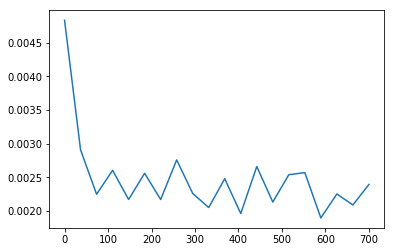

(50, 2)


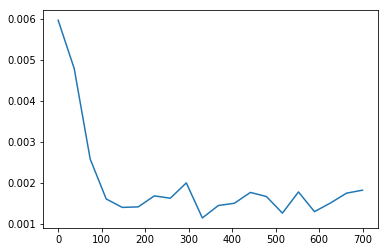

(50, 3)


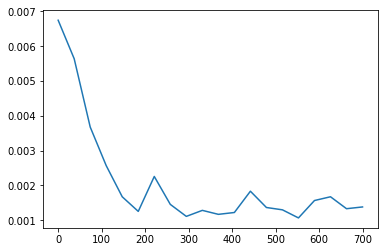

(70, 0.5)


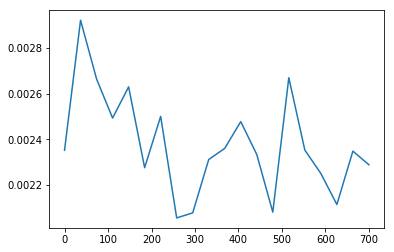

(70, 1)


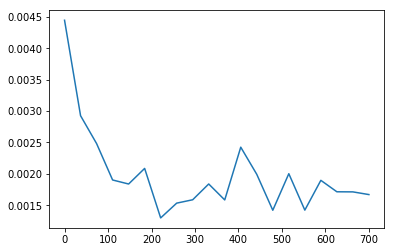

(70, 2)


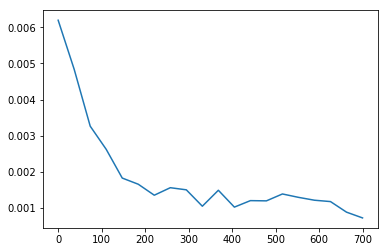

(70, 3)


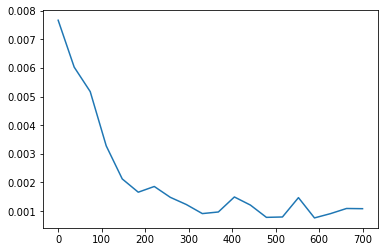

(90, 0.5)


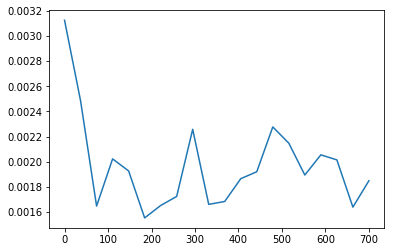

(90, 1)


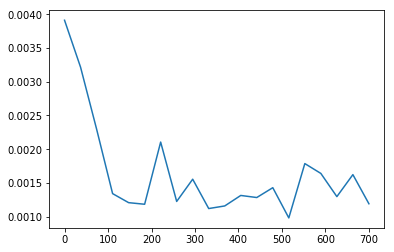

(90, 2)


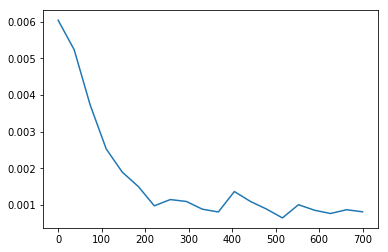

(90, 3)


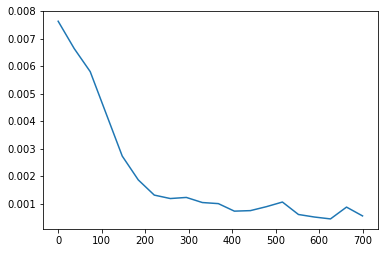

(100, 0.5)


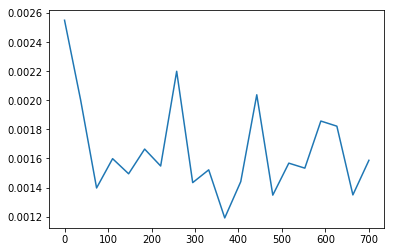

(100, 1)


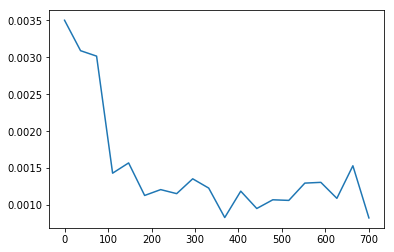

(100, 2)


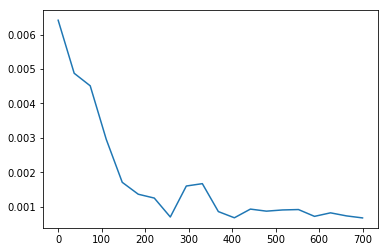

(100, 3)


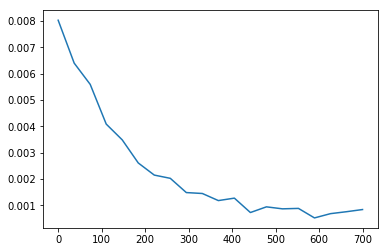

(110, 0.5)


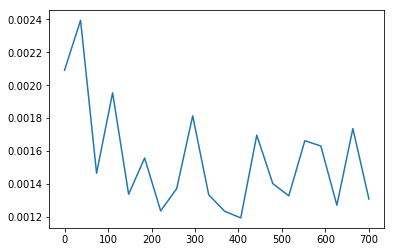

(110, 1)


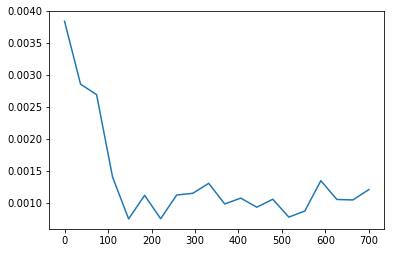

(110, 2)


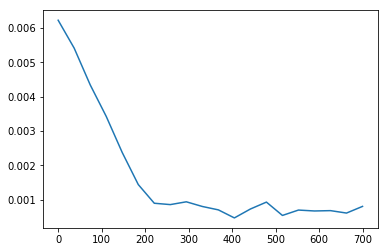

(110, 3)


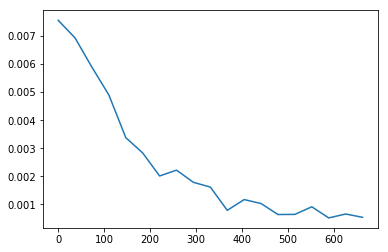

In [152]:
for i, val in enumerate(Mlist):
    print(paramlist[i])
    plt.plot(val)
    plt.show()
    

In [125]:
M1.index

Float64Index([        0.001, 36.8430526316, 73.6851052632, 110.527157895,
              147.369210526, 184.211263158, 221.053315789, 257.895368421,
              294.737421053, 331.579473684, 368.421526316, 405.263578947,
              442.105631579, 478.947684211, 515.789736842, 552.631789474,
              589.473842105, 626.315894737, 663.157947368],
             dtype='float64', name='Temperature')

In [5]:
info.dopant_neighbors,
#info.latlist[18], info.latlist[11]
# info = info()
# info.generate_lattice()
# info.plot_lattice()
# info.latlist

({20: [(33, 2, 15.076674036404714)],
  117: [(33, 2, 26.113565440207513)],
  33: [(20, 2, 15.076674036404714), (117, 2, 26.113565440207513)]},)

In [6]:
def m(T, Tc):
    return (abs(1 - (T/Tc)))**.36
thresh = 1
dat =M2

func1 = dat#.iloc[:thresh]
xdata1 = list(func1.index)
ydata1 = list(func1['Magnetization'])
popt1, pcov1 = curve_fit(m, xdata1, ydata1)

# func2 = dat.iloc[thresh:]
# xdata2 = list(func2.index)
# ydata2 = list(func2['Magnetization'])
# popt2, pcov2 = curve_fit(m, xdata2, ydata2)

plt.plot(xdata1,m(xdata1, *popt1))
#plt.plot(xdata2,m(xdata2, *popt2))
plt.plot(dat)
plt.show()
popt1

NameError: name 'M2' is not defined

In [170]:
df1

,Temperature,Energy,Magnetization


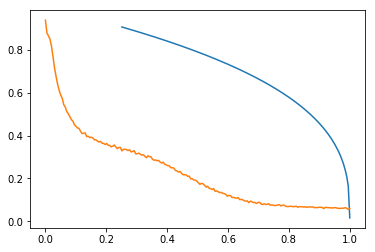

In [510]:
plt.plot(xdata,m(xdata,popt))
plt.plot(M4)
plt.show()